## **Loading the Dataset**

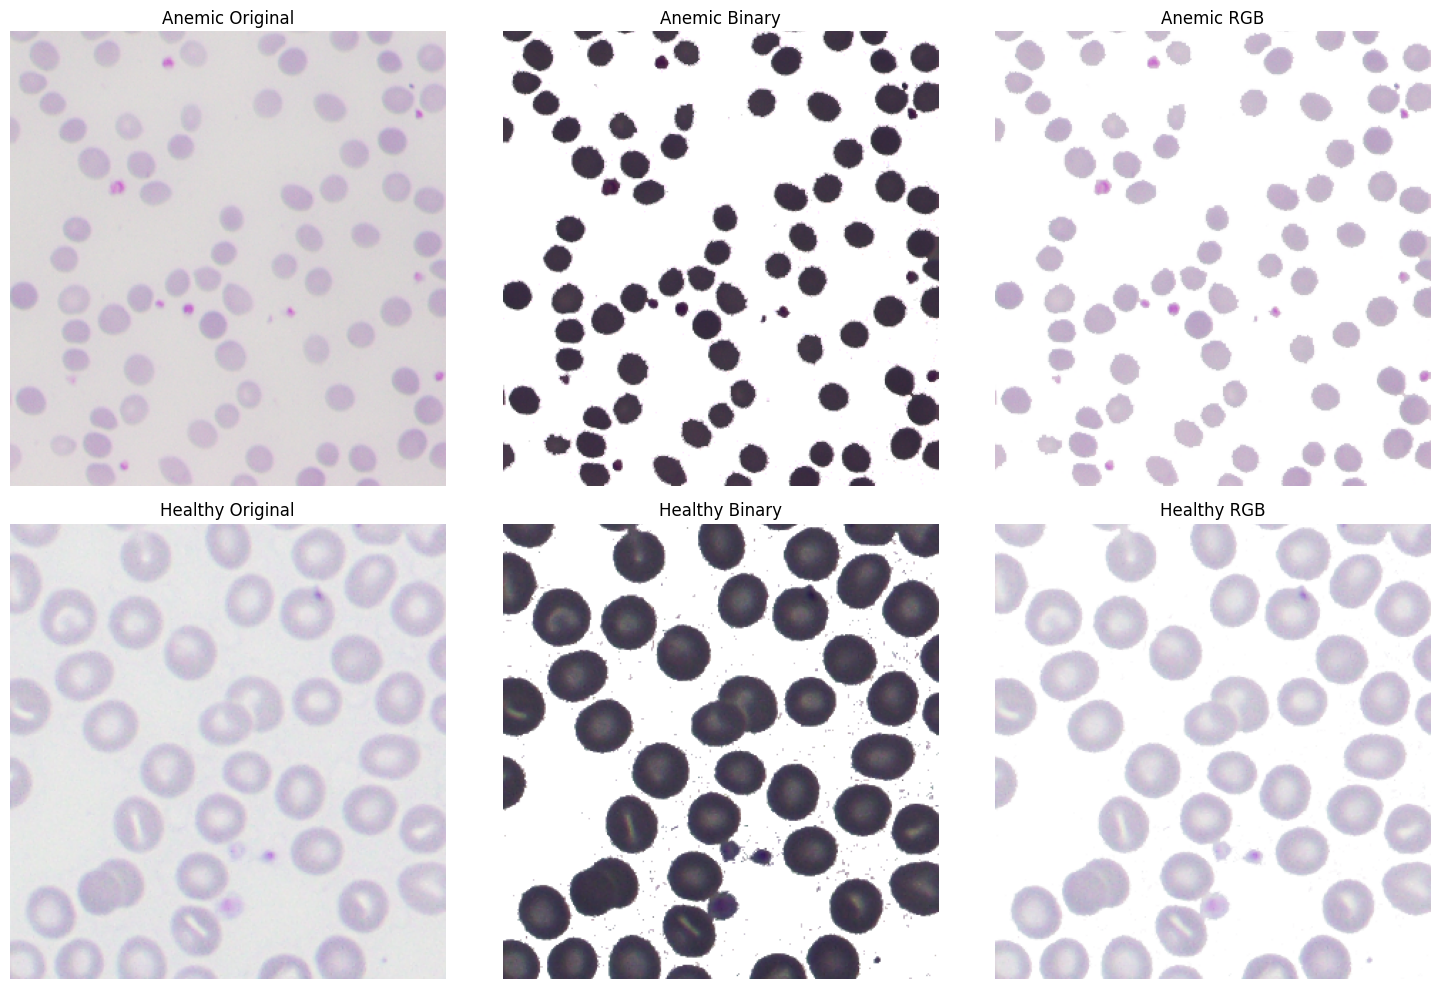

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define dataset paths (Stored in separate variables)
anemic_original =r"/kaggle/input/anerbc-dataset/AneRBC_dataset/AneRBC-II/Anemic_individuals/Original_images" 
anemic_binary =r"/kaggle/input/anerbc-dataset/AneRBC_dataset/AneRBC-II/Anemic_individuals/Binary_segmented"
anemic_rgb =r"/kaggle/input/anerbc-dataset/AneRBC_dataset/AneRBC-II/Anemic_individuals/RGB_segmented"


healthy_original =r"/kaggle/input/anerbc-dataset/AneRBC_dataset/AneRBC-II/Healthy_individuals/Original_images" 
healthy_binary =r"/kaggle/input/anerbc-dataset/AneRBC_dataset/AneRBC-II/Healthy_individuals/Binary_segmented"
healthy_rgb = r"/kaggle/input/anerbc-dataset/AneRBC_dataset/AneRBC-II/Healthy_individuals/RGB_segmented" 


# Store in a dictionary for structured access
directory = {
    "Anemic Original": anemic_original,
    "Anemic Binary": anemic_binary,
    "Anemic RGB": anemic_rgb,
    "Healthy Original": healthy_original,
    "Healthy Binary": healthy_binary,
    "Healthy RGB": healthy_rgb
}

# Display images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for 6 images

for ax, (label, path) in zip(axes.flatten(), directory.items()):
    sample_image_name = os.listdir(path)[110]  # Selecting the 110th image
    image_path = os.path.join(path, sample_image_name)
    img = Image.open(image_path)

    ax.imshow(img)  # Display image
    ax.set_title(f"{label}")  # Dataset category as title
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


In [3]:
import torch
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))


True Tesla T4


## **U-Net for Anemic Binary RBC**

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ✅ UNet Encoder Block
def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# ✅ UNet Decoder Block
def decoder_block(input_tensor, skip_tensor, num_filters):
    x = layers.UpSampling2D((2, 2))(input_tensor)
    x = layers.Concatenate()([x, skip_tensor])
    x = conv_block(x, num_filters)
    return x

# ✅ Full UNet Model
def build_unet(input_shape=(224, 224, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(bn, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    # Output layer: 1-channel sigmoid for binary mask
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d4)

    model = models.Model(inputs, outputs, name="UNet")
    return model

# ✅ Instantiate the model
unet_model = build_unet()
unet_model.summary()


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 224, 224, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 224, 224, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 112, 112, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 112, 112, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,401,345 (119.79 MB)

 Trainable params: 31,389,569 (119.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

## **Loading the data for Unet Model**

✅ Loaded 400 healthy images
✅ Loaded 400 anemic images


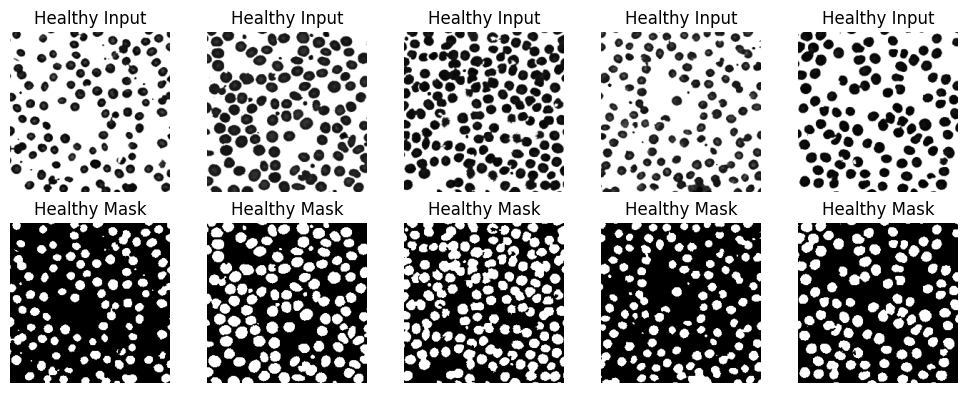

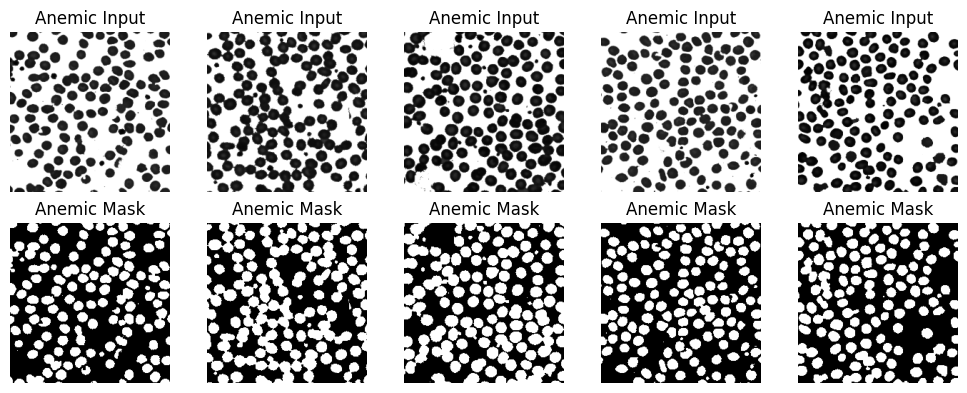

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# ✅ Function to load up to 400 binary images from a single directory
def load_binary_images(directory, img_size=(224, 224), max_images=400):
    images, masks = [], []
    file_list = sorted(os.listdir(directory))[:max_images]

    for file in file_list:
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue

        # Resize and normalize
        img_resized = cv2.resize(img, img_size)
        img_norm = img_resized / 255.0

        # ✅ Create binary mask where RBCs are black
        mask = (img_norm < 0.5).astype(np.uint8)

        images.append(img_norm)
        masks.append(mask)

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    masks = np.array(masks).reshape(-1, img_size[0], img_size[1], 1)

    return images, masks

# ✅ Load Healthy and Anemic Datasets Separately
healthy_images, healthy_masks = load_binary_images(healthy_binary)
anemic_images, anemic_masks   = load_binary_images(anemic_binary)

# ✅ Shuffle both datasets independently
healthy_images, healthy_masks = shuffle(healthy_images, healthy_masks, random_state=42)
anemic_images, anemic_masks   = shuffle(anemic_images, anemic_masks, random_state=42)

# ✅ Print stats
print(f"✅ Loaded {len(healthy_images)} healthy images")
print(f"✅ Loaded {len(anemic_images)} anemic images")

# ✅ Show sample inputs and masks for each
def show_samples(images, masks, title=""):
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"{title} Input")
        plt.axis("off")

        plt.subplot(2, 5, i+6)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title(f"{title} Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# ✅ Visual confirmation
show_samples(healthy_images, healthy_masks, title="Healthy")
show_samples(anemic_images, anemic_masks, title="Anemic")


## **Training the model**

In [6]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

# ✅ Combine healthy + anemic datasets for training
train_images = np.concatenate([healthy_images, anemic_images], axis=0)
train_masks  = np.concatenate([healthy_masks, anemic_masks], axis=0)

# ✅ Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

# ✅ Enable Multi-GPU Training
strategy = tf.distribute.MirroredStrategy()
print(f"✅ Using {strategy.num_replicas_in_sync} GPUs")

# ✅ Build and compile model inside strategy scope
with strategy.scope():
    unet_model = build_unet()
    unet_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
    )

# ✅ Train the model
history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16,
    shuffle=True,
    verbose=1
)

# ✅ Save final model (Kaggle-compatible)
unet_model.save("/kaggle/working/unet_combined.keras")
print("✅ Model saved as: /kaggle/working/unet_combined.keras")


✅ Using 2 GPUs
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 672ms/step - accuracy: 0.9226 - loss: 0.1792 - mean_io_u: 0.3133 - val_accuracy: 0.3963 - val_loss: 30.0674 - val_mean_io_u: 0.2299
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 624ms/step - accuracy: 0.9954 - loss: 0.0320 - mean_io_u: 0.3137 - val_accuracy: 0.4370 - val_loss: 1.6180 - val_mean_io_u: 0.3039
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 651ms/step - accuracy: 0.9972 - loss: 0.0185 - mean_io_u: 0.3134 - val_accuracy: 0.8016 - val_loss: 0.4875 - val_mean_io_u: 0.3039
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 690ms/step - accuracy: 0.9976 - loss: 0.0132 - mean_io_u: 0.3158 - val_accuracy: 0.6088 - val_loss: 0.8321 - val_mean_io_u: 0.3039
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 742ms/step - accuracy: 0.9974 - loss: 0.0109 - mean_io_u: 0.3114 - val_accuracy: 0.6085 - val_loss: 0.9037 - val_mean_io_u: 0.3039
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 722ms/step - accuracy: 0.9974 - loss: 0.0093 - mean_io_u: 0.3120 - val_accura

## **Predicting Mask**

✅ Using 2 GPUs
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step


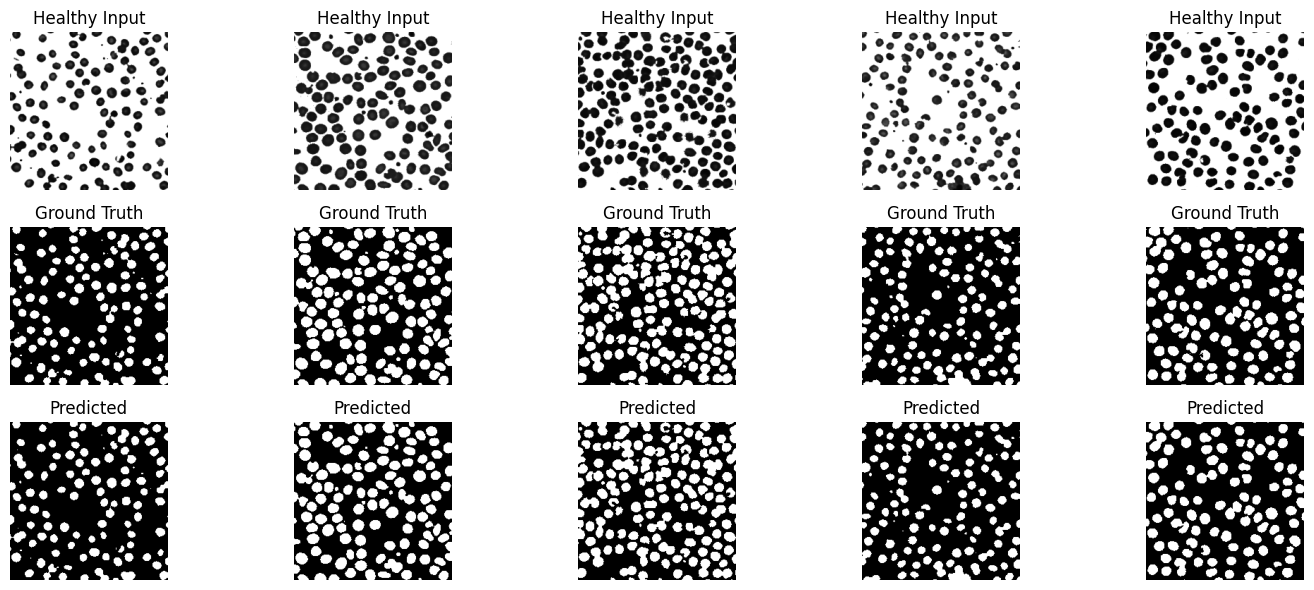

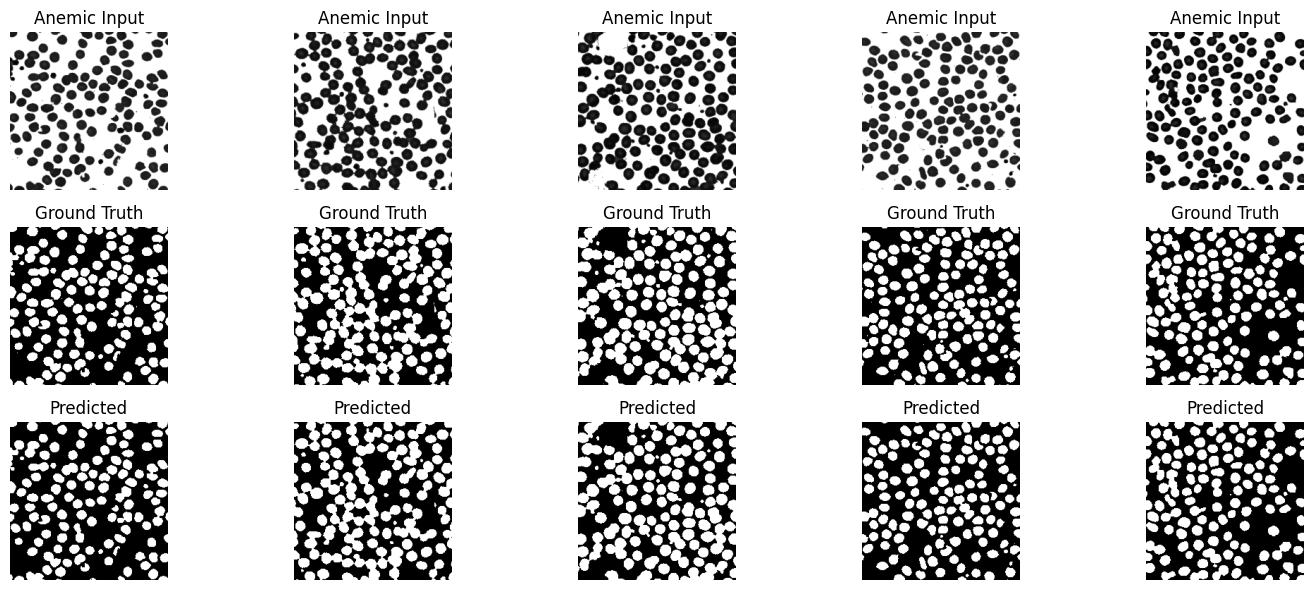

In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ✅ Use Multi-GPU Strategy
strategy = tf.distribute.MirroredStrategy()
print(f"✅ Using {strategy.num_replicas_in_sync} GPUs")

# ✅ Load trained model
with strategy.scope():
    unet_model = tf.keras.models.load_model("/kaggle/working/unet_combined.keras", compile=False)

# ✅ Predict binary masks
def predict_binary_masks(model, images, threshold=0.3):
    preds = model.predict(images, batch_size=16, verbose=1)
    binary = (preds > threshold).astype(np.uint8)
    return binary

# ✅ Predict on both sets
healthy_pred_masks = predict_binary_masks(unet_model, healthy_images)
anemic_pred_masks  = predict_binary_masks(unet_model, anemic_images)

# ✅ Visualize sample predictions
def show_predictions(images, true_masks, pred_masks, title=""):
    plt.figure(figsize=(15, 6))
    for i in range(5):
        plt.subplot(3, 5, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"{title} Input")
        plt.axis('off')

        plt.subplot(3, 5, i+6)
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(3, 5, i+11)
        plt.imshow(pred_masks[i].squeeze(), cmap='gray')
        plt.title("Predicted")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ Display healthy + anemic results
show_predictions(healthy_images, healthy_masks, healthy_pred_masks, title="Healthy")
show_predictions(anemic_images, anemic_masks, anemic_pred_masks, title="Anemic")


## **Contour Visualization (Watershed + Distance Transform)**

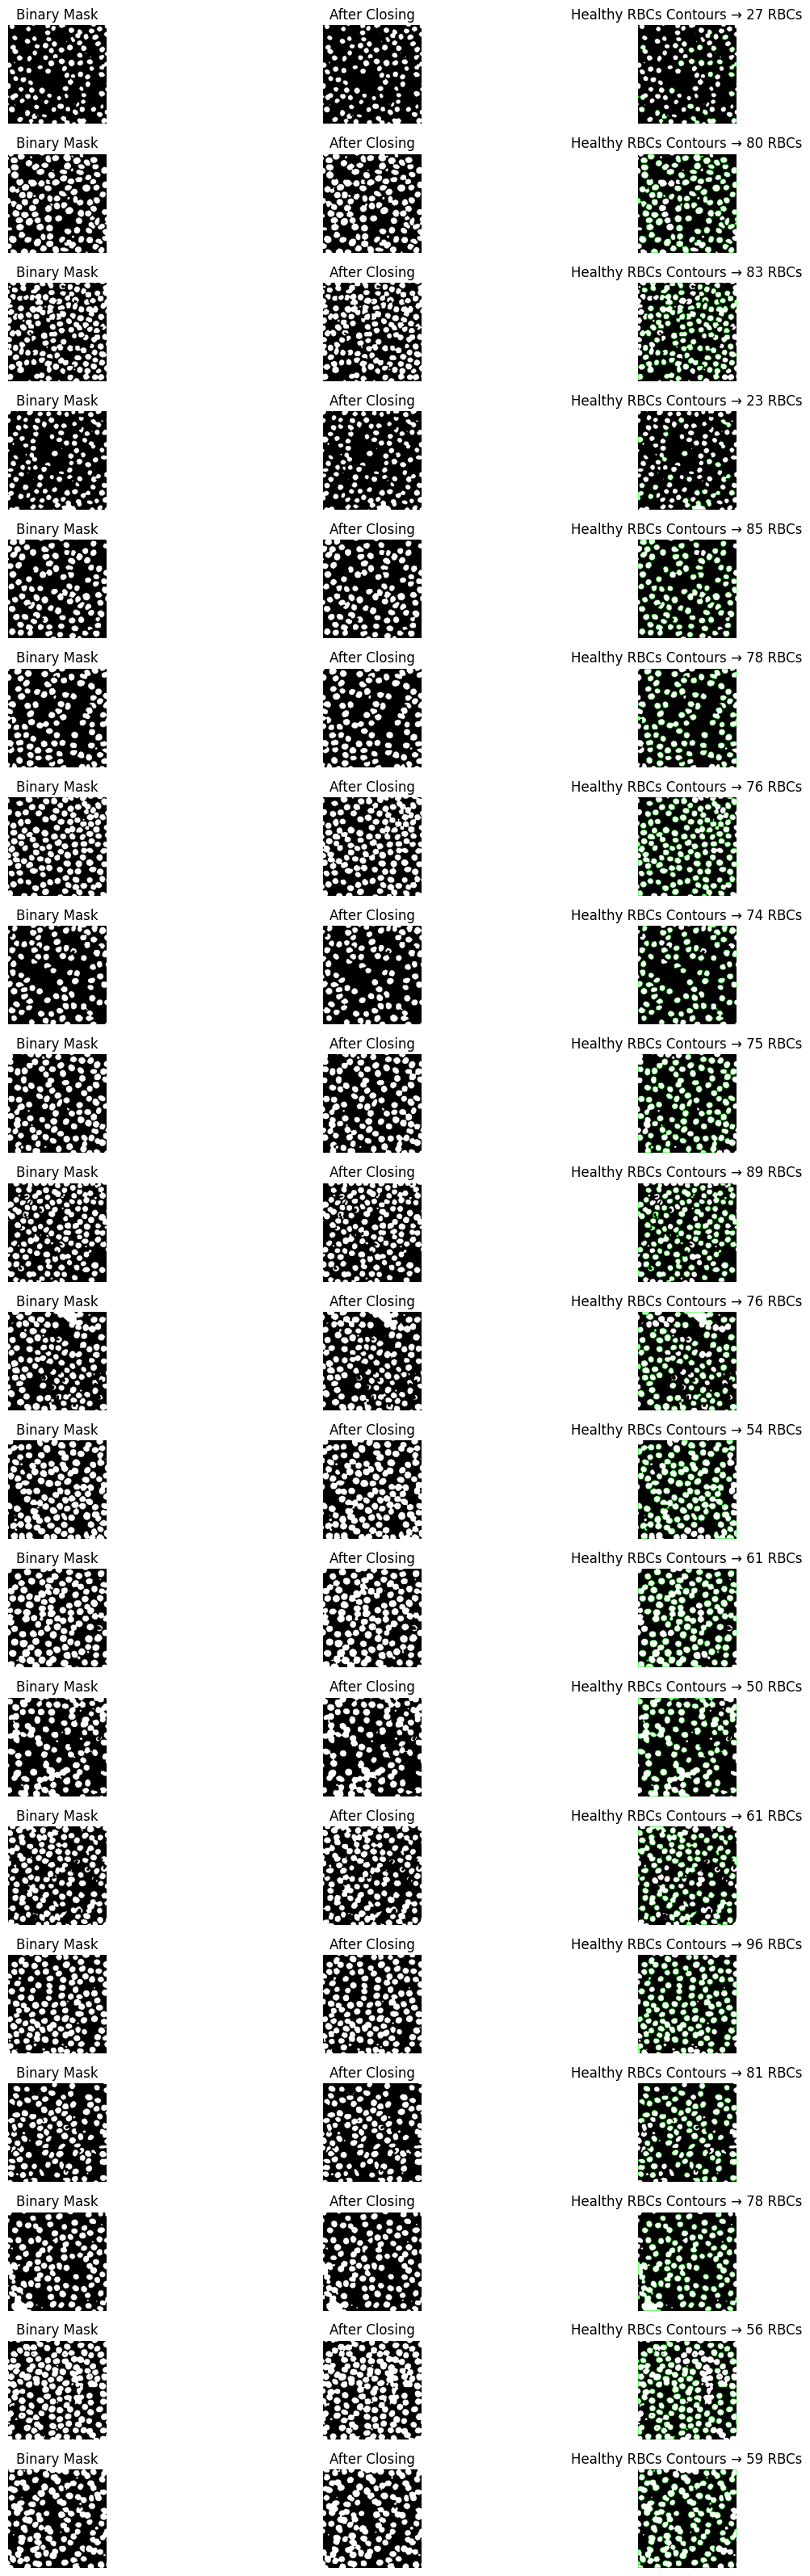

✅ Healthy RBCs Total RBCs (from 20 images): 1362
📊 Avg RBCs per image: 68.10


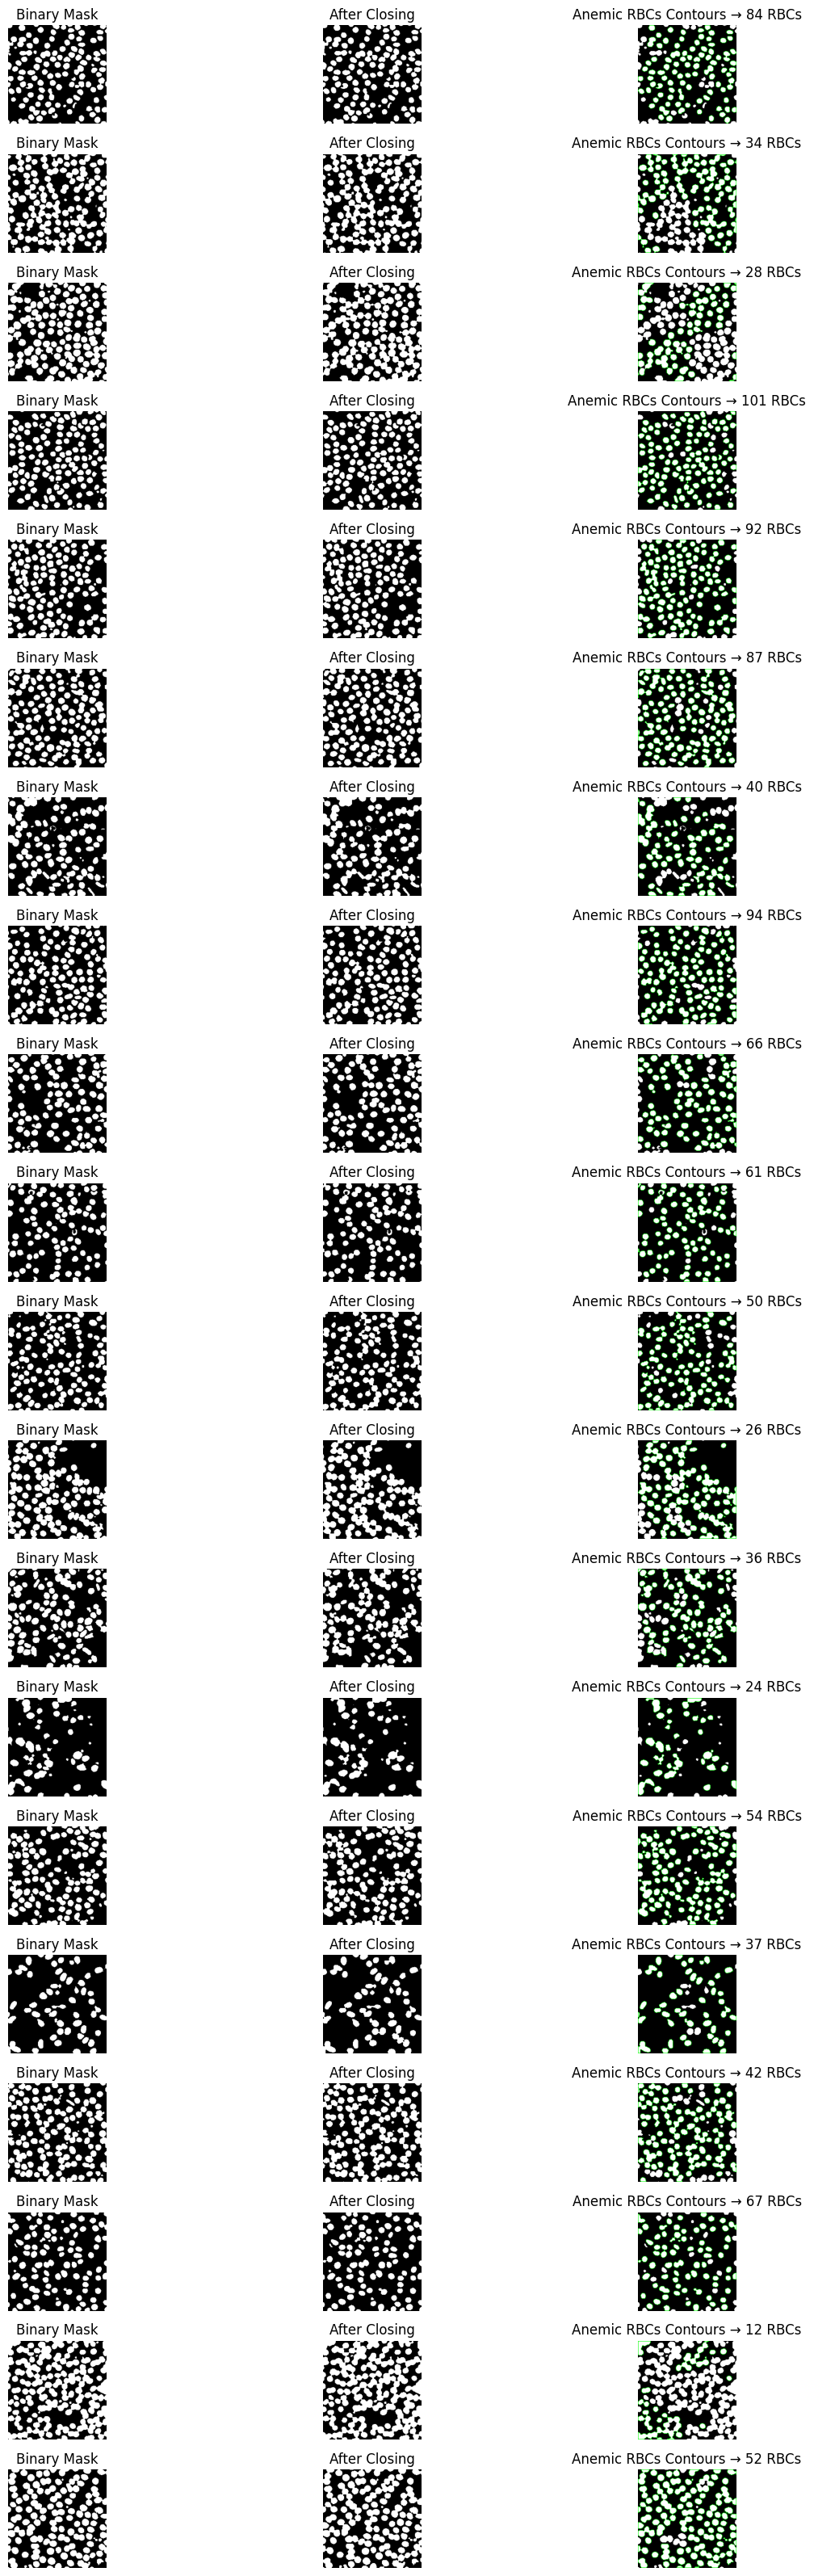

✅ Anemic RBCs Total RBCs (from 20 images): 1087
📊 Avg RBCs per image: 54.35


In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ✅ Load predicted binary masks (thresholded at 0.3 already)
healthy_pred_masks = np.load("/kaggle/working/healthy_pred_masks.npy")
anemic_pred_masks  = np.load("/kaggle/working/anemic_pred_masks.npy")

def detect_rbc_contours(mask, min_area=100, max_area=3000, ar_low=0.5, ar_high=1.8):
    """Detect individual RBC contours and remove clusters based on area/aspect ratio"""
    binary = (mask.squeeze() * 255).astype(np.uint8)

    # ✅ Step 1: Morphological Closing
    kernel = np.ones((3, 3), np.uint8)
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # ✅ Step 2: Find all contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ✅ Step 3: Filter individual RBCs
    filtered = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area or area > max_area:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / (h + 1e-5)
        if ar_low <= aspect_ratio <= ar_high:
            filtered.append(cnt)

    return filtered, binary, closed

# ✅ Visualize and Count
def visualize_and_count(masks, title_prefix="RBCs", num=20):
    total_rbc = 0
    plt.figure(figsize=(14, num * 1.6))
    
    for i in range(num):
        contours, bin_mask, closed_mask = detect_rbc_contours(masks[i])
        total_rbc += len(contours)

        vis = cv2.cvtColor(bin_mask, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(vis, contours, -1, (0, 255, 0), 1)

        plt.subplot(num, 3, i * 3 + 1)
        plt.imshow(bin_mask, cmap='gray')
        plt.title("Binary Mask")
        plt.axis("off")

        plt.subplot(num, 3, i * 3 + 2)
        plt.imshow(closed_mask, cmap='gray')
        plt.title("After Closing")
        plt.axis("off")

        plt.subplot(num, 3, i * 3 + 3)
        plt.imshow(vis)
        plt.title(f"{title_prefix} Contours → {len(contours)} RBCs")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    print(f"✅ {title_prefix} Total RBCs (from {num} images): {total_rbc}")
    print(f"📊 Avg RBCs per image: {total_rbc / num:.2f}")

# ✅ Visual Check with Filtering
visualize_and_count(healthy_pred_masks[:20], title_prefix="Healthy RBCs")
visualize_and_count(anemic_pred_masks[:20], title_prefix="Anemic RBCs")
